In [1]:
import os, sys
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.sigp import *
from mitequinox.plot import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=6, walltime='02:00:00')
w = cluster.scale(2*20)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

<Client: 'tcp://10.135.39.22:35753' processes=48 threads=288, memory=399.84 GB>

__________

# Read each terms

In [5]:
E_dir = '/work/ALT/swot/aval/syn/xy/momentum_balance/daily/'

F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
du_dt = xr.concat([xr.open_zarr(E_dir+'du_dt_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
dv_dt = xr.concat([xr.open_zarr(E_dir+'dv_dt_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
f_u = xr.concat([xr.open_zarr(E_dir+'fu_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
f_v = xr.concat([xr.open_zarr(E_dir+'fv_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
zeta_u = xr.concat([xr.open_zarr(E_dir+'zeta_u_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
zeta_v = xr.concat([xr.open_zarr(E_dir+'zeta_v_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
dKEdx = xr.concat([xr.open_zarr(E_dir+'dKE_dx_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
dKEdy = xr.concat([xr.open_zarr(E_dir+'dKE_dy_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
detadx = xr.concat([xr.open_zarr(E_dir+'deta_dx_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
detady = xr.concat([xr.open_zarr(E_dir+'deta_dy_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
residuals_u = xr.concat([xr.open_zarr(E_dir+'residuals_u_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
residuals_v = xr.concat([xr.open_zarr(E_dir+'residuals_v_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')

dudt = du_dt.du_dt
dvdt = dv_dt.dv_dt
fu = f_u.fu
fv = f_v.fv
zeta_u = zeta_u.zeta_u
zeta_v = zeta_v.zeta_v
dKE_dx = dKEdx.dKE_dx
dKE_dy = dKEdy.dKE_dy
deta_dx = detadx.deta_dx
deta_dy = detady.deta_dy
residuals_u = residuals_u.residuals_u
residuals_v = residuals_v.residuals_v

distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [6]:
linear_corilis = np.sqrt( (fu**2).mean(['time']) + (fv**2).mean(['time']) )
pressure_gradient = np.sqrt( (deta_dx**2).mean(['time'])+(deta_dy**2).mean(['time']) )
f_ageo = np.sqrt( ((-fv+deta_dx)**2).mean(['time']) + ((fu+deta_dy)**2).mean(['time'])  )
acceleration = np.sqrt( (dudt**2).mean(['time']) + (dvdt**2).mean(['time']) )
nonlinear_advection = np.sqrt( ((-zeta_v+dKE_dx)**2).mean(['time']) + ((zeta_u+dKE_dy)**2).mean(['time']) )
residuals = np.sqrt( (residuals_u**2).mean(['time']) + (residuals_v**2).mean(['time']) )
DuDt = np.sqrt( ((dudt-zeta_v+dKE_dx)**2).mean(['time']) + ((dvdt+zeta_u+dKE_dy)**2).mean(['time']) )
DuDt_residuals = np.sqrt( ((dudt-zeta_v+dKE_dx)**2).mean(['time']) + ((dvdt+zeta_u+dKE_dy)**2).mean(['time']) )

linear_corilis = np.real(linear_corilis).rename('linear_corilis')
pressure_gradient = np.real(pressure_gradient).rename('pressure_gradient')
f_ageo = np.real(f_ageo).rename('f_ageo')
acceleration = np.real(acceleration).rename('acceleration')
nonlinear_advection = np.real(nonlinear_advection).rename('nonlinear_advection')
residuals = np.real(residuals).rename('residuals')
DuDt = np.real(DuDt).rename('DuDt')

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [7]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for face in F:
    
    linear_corilis = np.sqrt( (fu.isel(face=face)**2).mean(['time']) + (fv.isel(face=face)**2).mean(['time']) )
    pressure_gradient = np.sqrt( (deta_dx.isel(face=face)**2).mean(['time'])+(deta_dy.isel(face=face)**2).mean(['time']) )
    f_ageo = np.sqrt( ((-fv.isel(face=face)+deta_dx.isel(face=face))**2).mean(['time']) + ((fu.isel(face=face)+deta_dy.isel(face=face))**2).mean(['time'])  )
    acceleration = np.sqrt( (dudt.isel(face=face)**2).mean(['time']) + (dvdt.isel(face=face)**2).mean(['time']) )
    nonlinear_advection = np.sqrt( ((-zeta_v.isel(face=face)+dKE_dx.isel(face=face))**2).mean(['time']) + ((zeta_u.isel(face=face)+dKE_dy.isel(face=face))**2).mean(['time']) )
    residuals = np.sqrt( (residuals_u.isel(face=face)**2).mean(['time']) + (residuals_v.isel(face=face)**2).mean(['time']) )
    DuDt = np.sqrt( ((dudt.isel(face=face)-zeta_v.isel(face=face)+dKE_dx.isel(face=face))**2).mean(['time']) + ((dvdt.isel(face=face)+zeta_u.isel(face=face)+dKE_dy.isel(face=face))**2).mean(['time']) )
    
    linear_corilis = np.real(linear_corilis).rename('linear_corilis')
    pressure_gradient = np.real(pressure_gradient).rename('pressure_gradient')
    f_ageo = np.real(f_ageo).rename('f_ageo')
    acceleration = np.real(acceleration).rename('acceleration')
    nonlinear_advection = np.real(nonlinear_advection).rename('nonlinear_advection')
    residuals = np.real(residuals).rename('residuals')
    DuDt = np.real(DuDt).rename('DuDt')
    
    rms = xr.merge([linear_corilis, pressure_gradient, f_ageo, acceleration, nonlinear_advection, residuals, DuDt])
    Efile = E_dir+'rms_f%02d.zarr'%face
    rms.to_zarr(Efile, mode='w')
    print('--- face %d done'%face)

--- face 0 done
--- face 1 done
--- face 2 done


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


--- face 3 done


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

--- face 4 done


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


--- face 5 done


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


--- face 6 done


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


--- face 7 done


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

--- face 8 done


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


--- face 9 done


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


--- face 10 done


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


--- face 11 done


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

--- face 12 done


In [6]:
ds_R = xr.open_dataset('/work/ALT/swot/aval/syn/xy/R_rms.nc')
ds_R

<xarray.Dataset>
Dimensions:        (face: 13, i: 1080, j: 1080)
Coordinates:
  * i              (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j              (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    CS             (face, j, i) float32 ...
    Depth          (face, j, i) float32 ...
    SN             (face, j, i) float32 ...
    XC             (face, j, i) float32 ...
    YC             (face, j, i) float32 ...
  * face           (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    rA             (face, j, i) float32 ...
    hFacC          (face, j, i) float32 ...
Data variables:
    Tau_ELD_rms    (face, j, i) float32 ...
    Residuals_rms  (face, j, i) float32 ...
    Diff_rms       (face, j, i) float32 ...

In [ ]:
# save residual term, transfer to datarmor to do comparisons

E_dir = '/work/ALT/swot/aval/syn/xy/momentum_balance/daily/'

F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

residuals_u = xr.concat([xr.open_zarr(E_dir+'residuals_u_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
residuals_v = xr.concat([xr.open_zarr(E_dir+'residuals_v_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')

residuals_u = residuals_u.residuals_u
residuals_v = residuals_v.residuals_v

residuals_u_rms = np.sqrt( (residuals_u**2).mean(['time']) )
residuals_v_rms = np.sqrt( (residuals_v**2).mean(['time']) )
residuals_rms = np.sqrt( (residuals_u**2).mean(['time']) + (residuals_v**2).mean(['time']) )

residuals_u_rms = np.real(residuals_u_rms).rename('residuals_u_rms')
residuals_v_rms = np.real(residuals_v_rms).rename('residuals_v_rms')
residuals_rms = np.real(residuals_rms).rename('residuals_rms')

residuals_rms = xr.merge([residuals_u_rms,residuals_v_rms, residuals_rms])
print(residuals_rms)
data_dir = '/work/ALT/swot/aval/syn/xy/momentum_balance/data/'
residuals_rms.to_netcdf(data_dir+'residuals_rms.nc', mode='w')  

### RMS plots

In [5]:
ds_ice = xr.open_zarr(work_data_dir+'xy/sea_ice_mask.zarr')
dij=4 
ice = ds_ice.AREA.isel(i=slice(0,None,dij), j=slice(0,None,dij)) 

E_dir = '/work/ALT/swot/aval/syn/xy/momentum_balance/daily/'
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
rms = xr.concat([xr.open_zarr(E_dir+'rms_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
rms

<xarray.Dataset>
Dimensions:              (face: 13, i: 1080, j: 1080)
Coordinates:
  * i                    (i) int64 0 4 8 12 16 20 ... 4300 4304 4308 4312 4316
  * j                    (j) int64 0 4 8 12 16 20 ... 4300 4304 4308 4312 4316
    CS                   (face, j, i) float32 dask.array<chunksize=(1, 270, 540), meta=np.ndarray>
    Depth                (face, j, i) float32 dask.array<chunksize=(1, 270, 540), meta=np.ndarray>
    SN                   (face, j, i) float32 dask.array<chunksize=(1, 270, 540), meta=np.ndarray>
    XC                   (face, j, i) float32 dask.array<chunksize=(1, 270, 540), meta=np.ndarray>
    YC                   (face, j, i) float32 dask.array<chunksize=(1, 270, 540), meta=np.ndarray>
  * face                 (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    hFacC                (face, j, i) float32 dask.array<chunksize=(1, 270, 540), meta=np.ndarray>
    rA                   (face, j, i) float32 dask.array<chunksize=(1, 270, 540), meta=np.ndarray

In [6]:
font_size = 32

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='thermal',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
        cmap = getattr(cm, cmmap)
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC>=0) & (vplt.XC<=180.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                im = vplt.where(vplt.XC<=0).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                
        cax = plt.axes([0.925, 0.25, 0.025, 0.5])
        cb = plt.colorbar(im, cax=cax, ticks=[0, 1e-5, 2e-5, 3e-5,4e-5])
        cb.ax.set_yticklabels(['0','1','2','3','4'])
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
        ax.set_xticklabels(['$180\degree$W','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$E'])
        ax.set_ylim(-70., 70.)
        ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
        ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=150)
            plt.close(fig)
        #
        if not offline:
            plt.show()
            

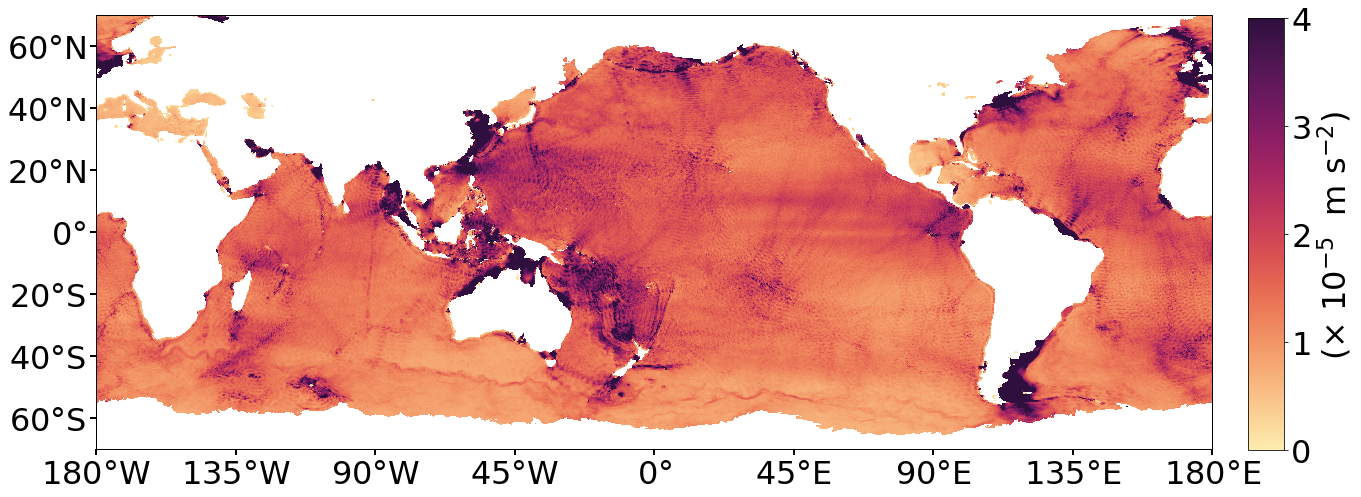

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


In [11]:
plot_pretty(rms.acceleration.where(ice>0), label=r'($\times$ 10$^{-5}$  m s$^{-2}$)', vmin=0, vmax=4e-5, cmmap='matter', ignore_face=[6])

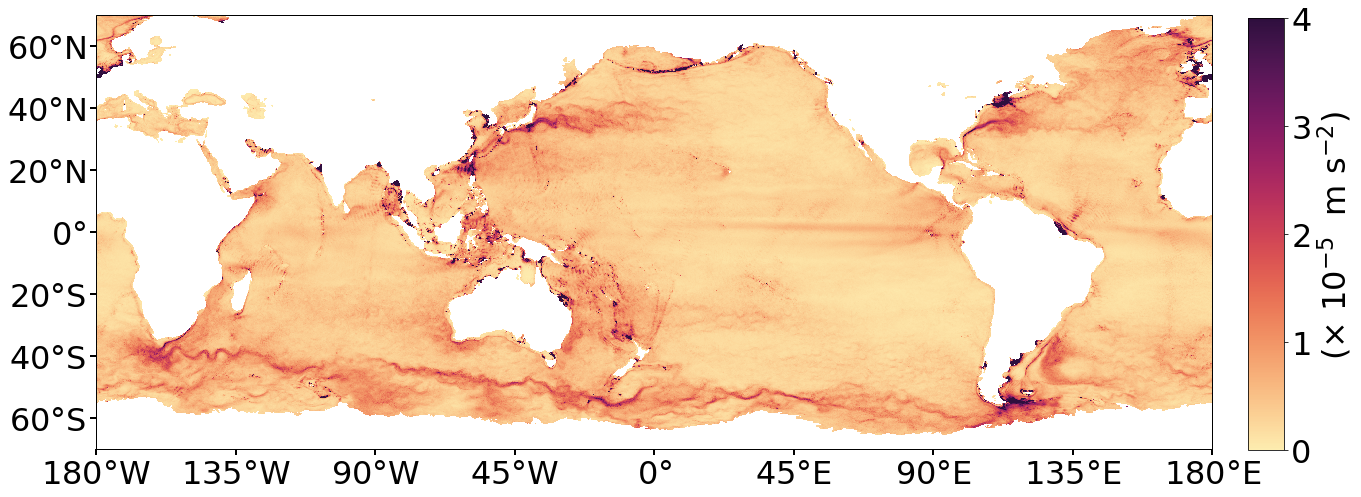

In [7]:
plot_pretty(rms.nonlinear_advection.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0), label=r'($\times$ 10$^{-5}$  m s$^{-2}$)', vmin=0, vmax=4e-5, cmmap='matter', ignore_face=[6])

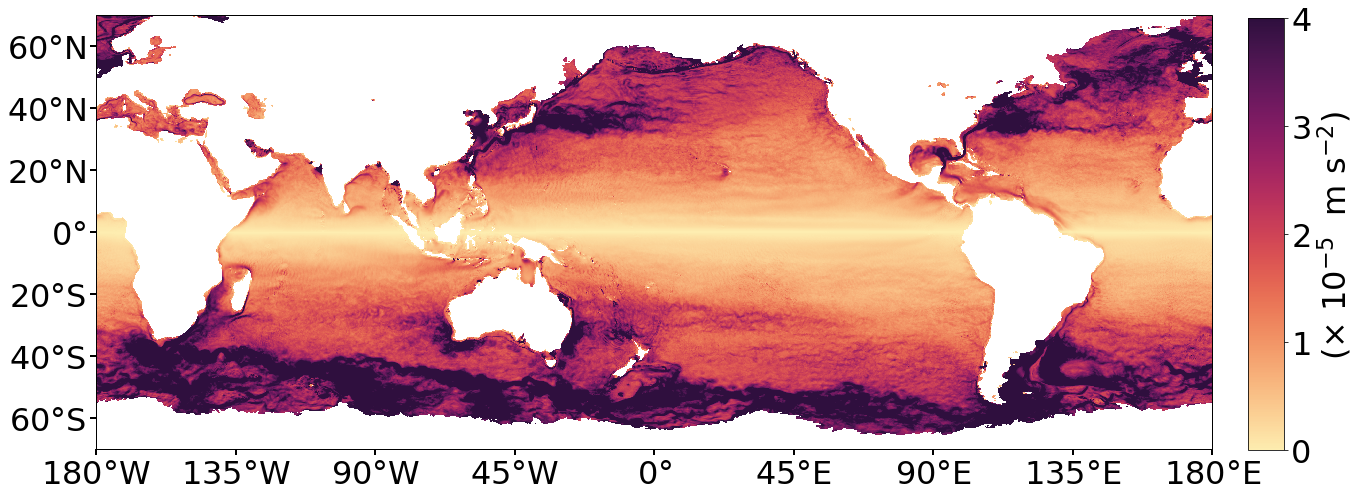

In [8]:
plot_pretty(rms.linear_corilis.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0), label=r'($\times$ 10$^{-5}$  m s$^{-2}$)', vmin=0, vmax=4e-5, cmmap='matter', ignore_face=[6])

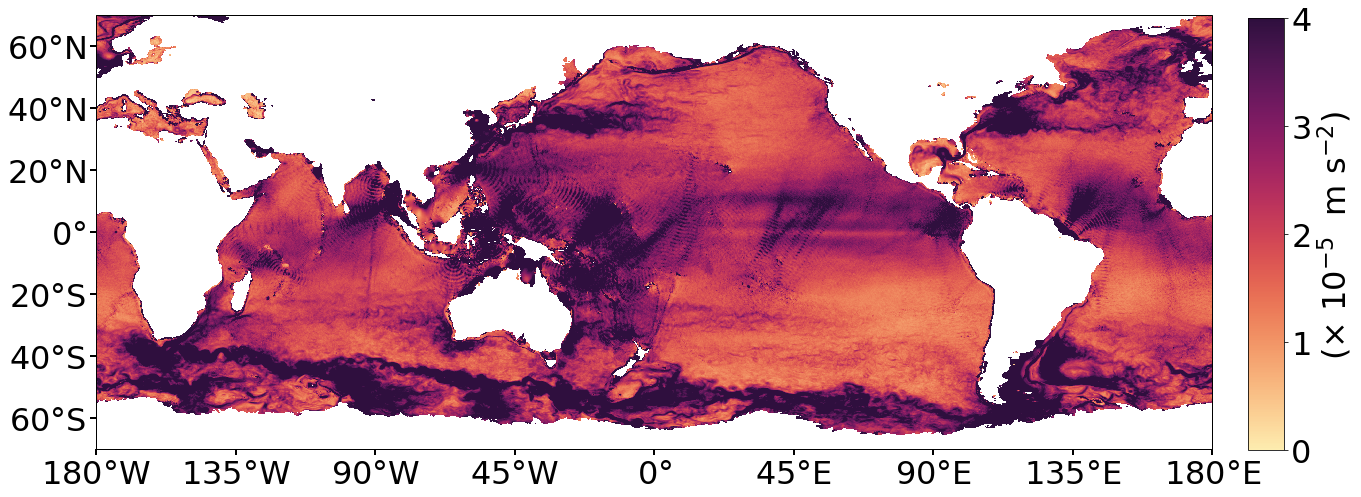

In [9]:
plot_pretty(rms.pressure_gradient.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0), label=r'($\times$ 10$^{-5}$  m s$^{-2}$)', vmin=0, vmax=4e-5, cmmap='matter', ignore_face=[6])

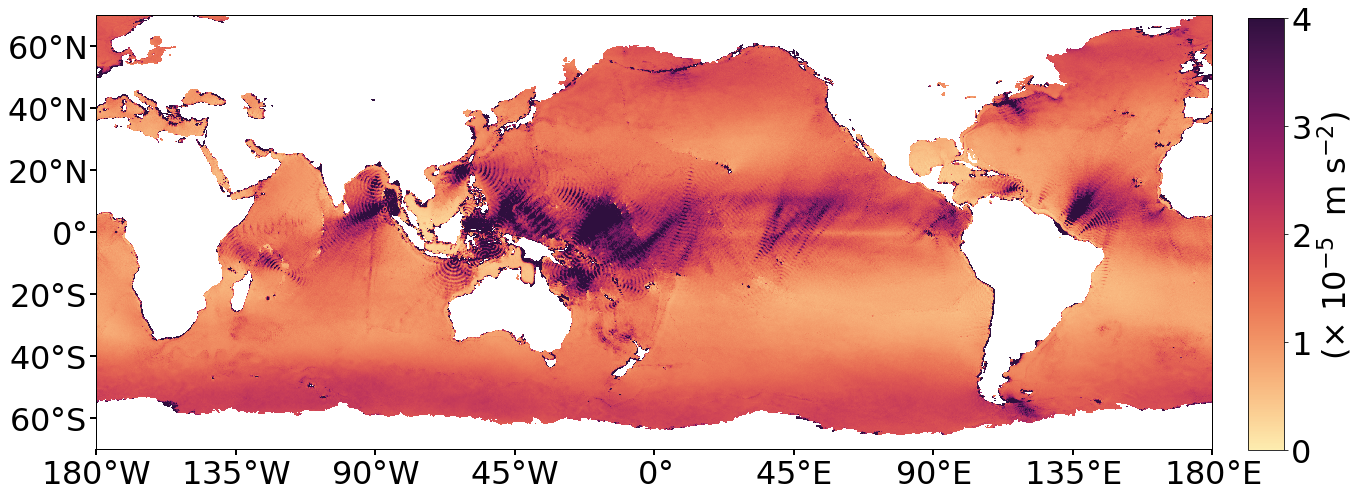

In [10]:
plot_pretty(rms.residuals.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0), label=r'($\times$ 10$^{-5}$  m s$^{-2}$)', vmin=0, vmax=4e-5, cmmap='matter', ignore_face=[6])

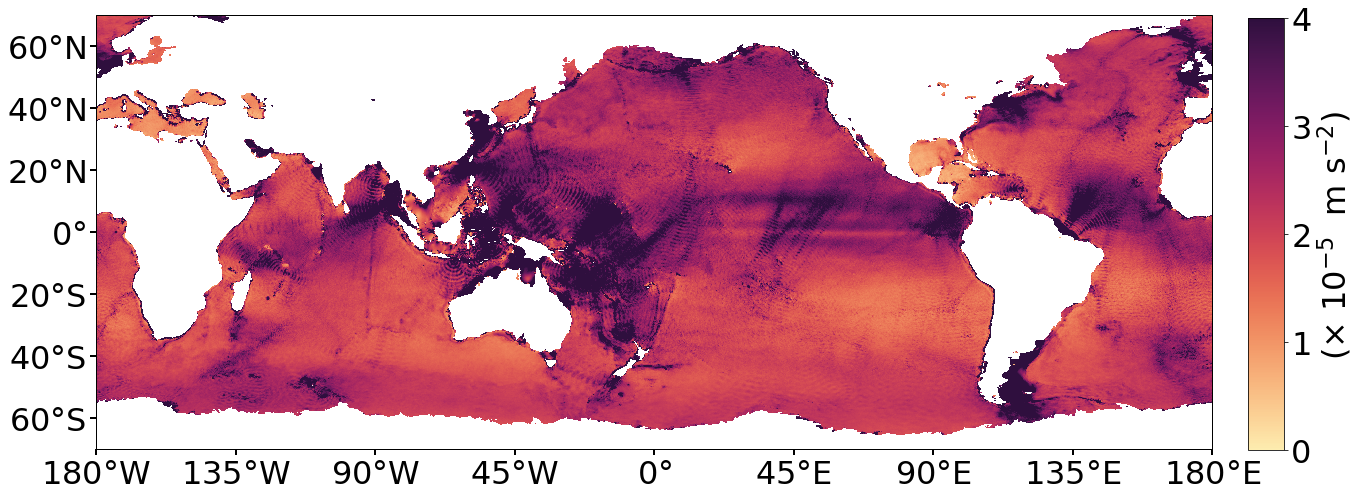

In [11]:
plot_pretty(rms.f_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0), label=r'($\times$ 10$^{-5}$  m s$^{-2}$)', vmin=0, vmax=4e-5, cmmap='matter', ignore_face=[6])

## Ratio

In [12]:
font_size = 32

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='Greens_r',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
        #cmap = getattr(cm, cmmap)
        #cmap = cmmap
        cmmap=plt.cm.get_cmap('Greens_r', 10)
        cmap = cmmap
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC>=0) & (vplt.XC<=180.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                im = vplt.where(vplt.XC<=0).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                
        cax = plt.axes([0.925, 0.25, 0.025, 0.5])
        cb = plt.colorbar(im, cax=cax, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
        #cb.ax.set_yticklabels(['10$^{-2}$','10$^{-1}$','10$^0$'])
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
        ax.set_xticklabels(['$180\degree$W','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$E'])
        ax.set_ylim(-70., 70.)
        ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
        ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=150)
            plt.close(fig)
        #
        if not offline:
            plt.show()
            

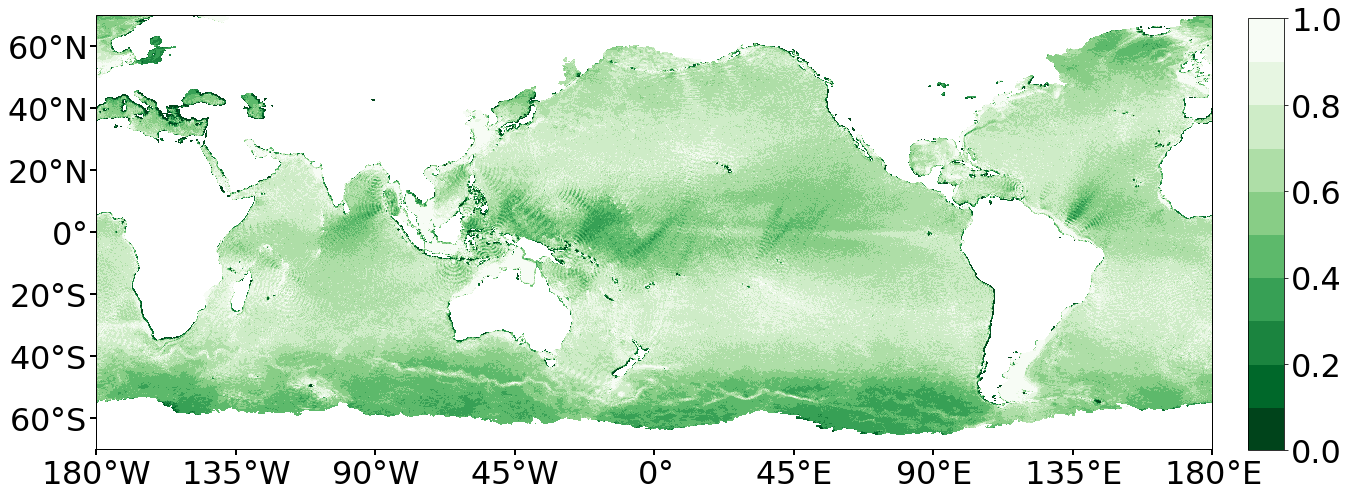

In [13]:
plot_pretty( rms.acceleration.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)/rms.f_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0), label='', vmin=0, vmax=1, cmmap='Greens_r', ignore_face=[6])

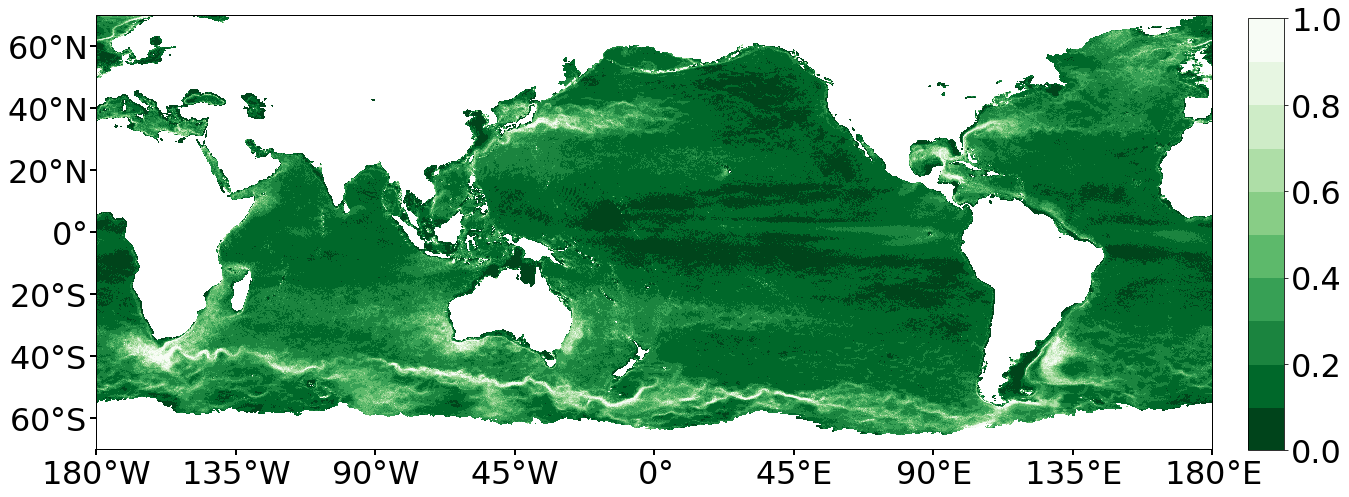

In [14]:
plot_pretty( rms.nonlinear_advection.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)/rms.f_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0), label='', vmin=0, vmax=1, cmmap='Greens_r', ignore_face=[6])

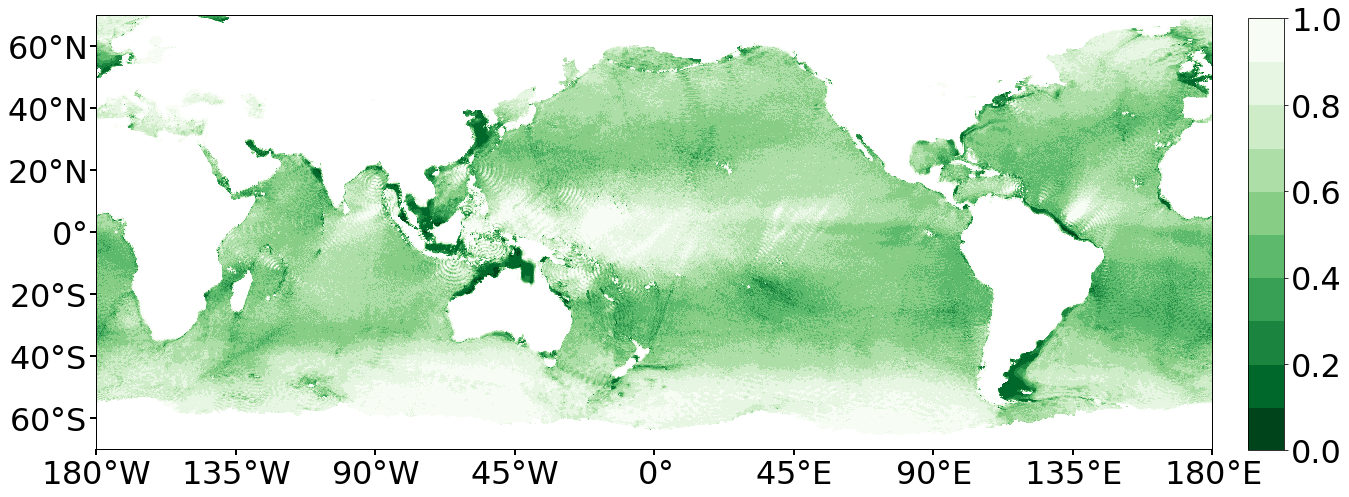

In [15]:
plot_pretty( rms.residuals.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)/rms.f_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0), label='', vmin=0, vmax=1, cmmap='Greens_r', ignore_face=[6])

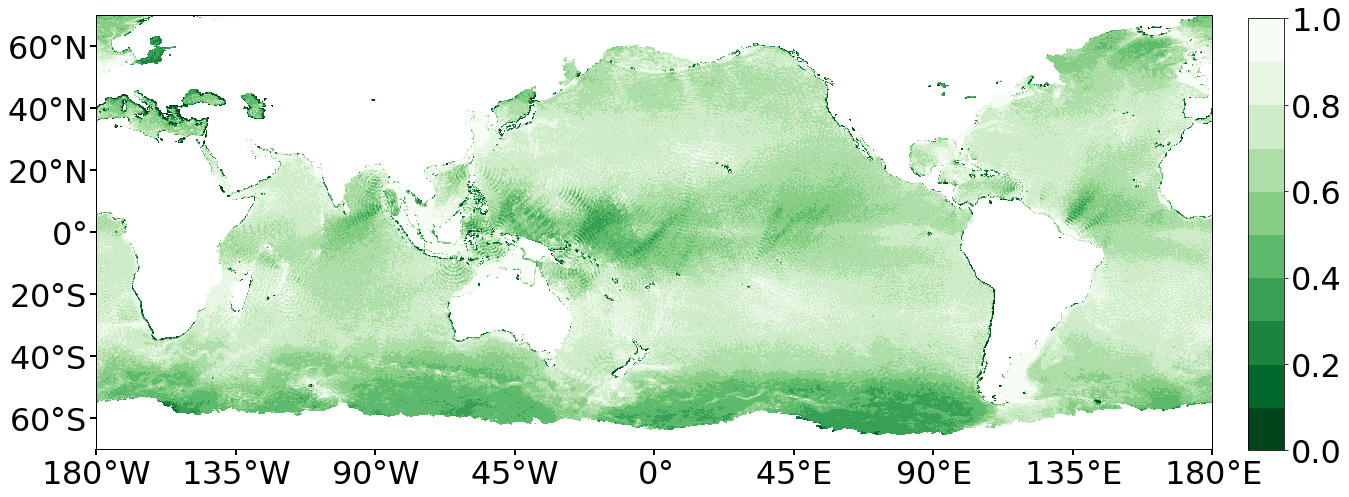

In [16]:
plot_pretty( rms.DuDt.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)/rms.f_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0), label='', vmin=0, vmax=1, cmmap='Greens_r', ignore_face=[6])

In [10]:
font_size = 32

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='Greens_r',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
        #cmap = getattr(cm, cmmap)
        #cmap = cmmap
        cmmap=plt.cm.get_cmap('Greens_r', 10)
        cmap = cmmap
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC>=0) & (vplt.XC<=180.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                im = vplt.where(vplt.XC<=0).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                
        #cax = plt.axes([0.925, 0.25, 0.025, 0.5])
        cax = plt.axes([0.925, 0.285, 0.025, 0.43])
        cb = plt.colorbar(im, cax=cax, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
        #cb.ax.set_yticklabels(['10$^{-2}$','10$^{-1}$','10$^0$'])
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
        ax.set_xticklabels(['$180\degree$W','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$E'])
        ax.set_ylim(-60., 60.)
        ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
        ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=150)
            plt.close(fig)
        #
        if not offline:
            plt.show()
            

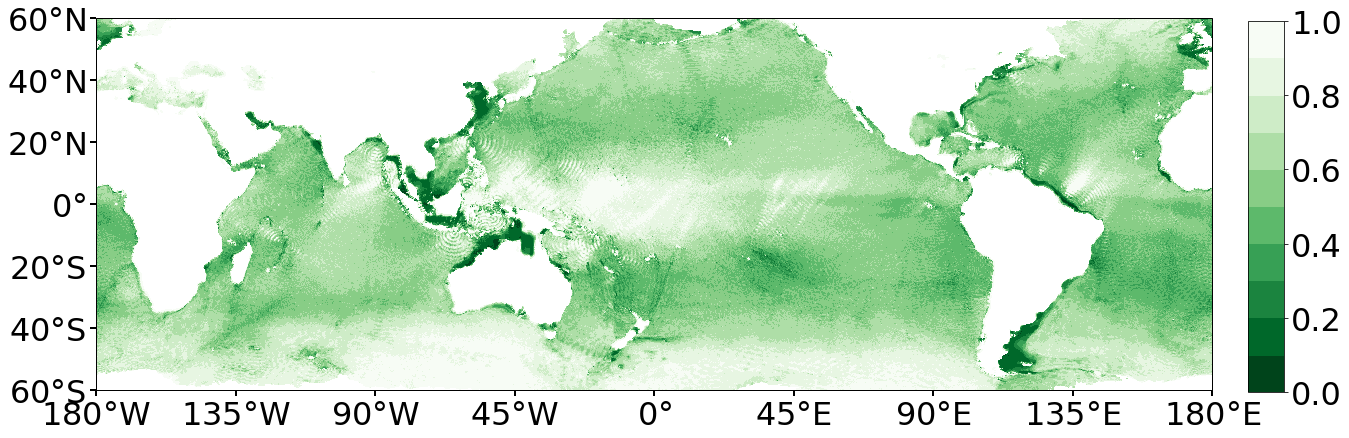

In [20]:
plot_pretty( rms.residuals.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)/rms.f_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0), label='', vmin=0, vmax=1, cmmap='Greens_r', ignore_face=[6])

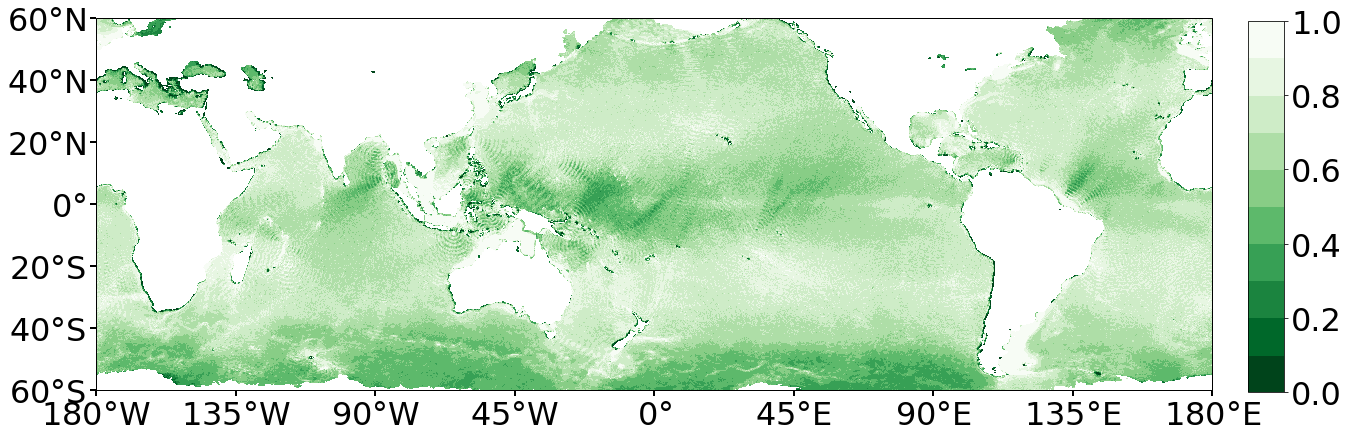

In [21]:
plot_pretty( rms.DuDt.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)/rms.f_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0), label='', vmin=0, vmax=1, cmmap='Greens_r', ignore_face=[6])

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


Text(0.5, 0, '')

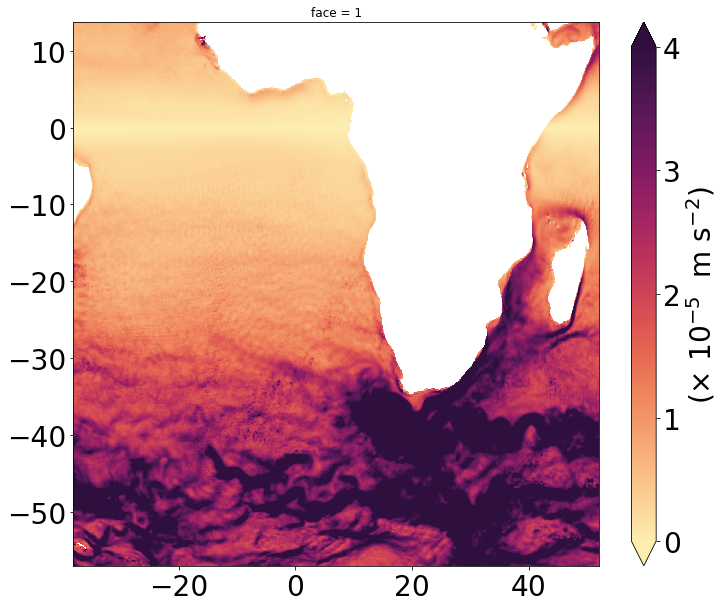

In [13]:
font_size =28
fig = plt.figure(figsize=(40,10))

ax = plt.subplot(131)
cax=linear_corilis.isel(face=1).plot(x='XC', y='YC', vmin=0,vmax=4e-5,cmap=cm.matter, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical', ticks=[0, 1e-5, 2e-5, 3e-5, 4e-5])
cbar.ax.set_yticklabels(['0','1','2','3','4'])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label(r'($\times$ 10$^{-5}$  m s$^{-2}$)', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


Text(0.5, 0, '')

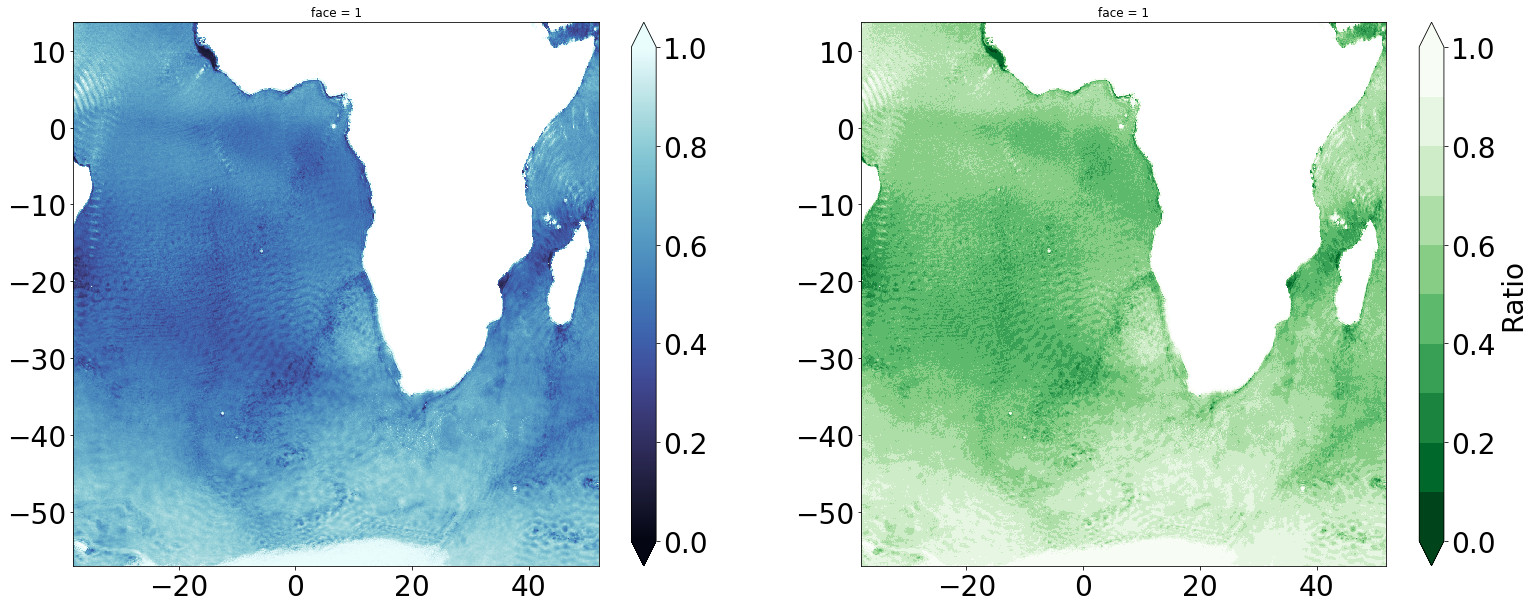

In [13]:
font_size =28

fig = plt.figure(figsize=(40,10))

ax = plt.subplot(131)
cax=(residuals.isel(face=1)/f_ageo.isel(face=1)).plot(x='XC', y='YC',vmin=0,vmax=1, cmap=cm.ice, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(132)
cax=(residuals.isel(face=1)/f_ageo.isel(face=1)).plot(x='XC', y='YC',vmin=0,vmax=1, cmap=plt.cm.get_cmap('Greens_r', 10), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

In [12]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1005, in _reconnect
    await self._close()
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=